In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\asgar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data from CSV
data = pd.read_csv('data.csv')

# Drop the timestamp
data = data.drop(['timestamp'], axis=1)

# Split data into 80% training and 20% testing
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Separate the testing data into normal (5%) and anomalies (15%)
normal_data = test_data.sample(frac=0.25, random_state=42)  # 5% normal (25% of 20%)
anomaly_data = test_data.drop(normal_data.index)  # Remaining 15% will be anomalies
y_true = np.concatenate([np.ones(len(normal_data)), np.zeros(len(anomaly_data))])

In [3]:
# Systematically introduce anomalies into the normal data
anomaly_data['ram_usage'] = anomaly_data['ram_usage'] * 1.25
anomaly_data['ram_usage'] = anomaly_data['ram_usage'].clip(upper=1.0)

anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'] * 1.50
anomaly_data['cpu_usage'] = anomaly_data['cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'] * 1.60
anomaly_data['average_process_cpu_usage'] = anomaly_data['average_process_cpu_usage'].clip(upper=1.0)

anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'] * 1.30
anomaly_data['average_process_ram_usage'] = anomaly_data['average_process_ram_usage'].clip(upper=1.0)

anomaly_data['network_bytes_sent'] = anomaly_data['network_bytes_sent'] * 1.10

In [4]:
# Combine back the normal and anomalous data for testing
test_data = pd.concat([normal_data, anomaly_data])

# List of columns that are already scaled and should not be scaled again
already_scaled_columns = ['cpu_usage', 'ram_usage', 'vram_usage', 'average_process_cpu_usage', 'average_process_ram_usage']

# Select columns that need scaling by excluding already scaled columns
columns_to_scale = [col for col in train_data.columns if col not in already_scaled_columns]

# Apply scaling only to the columns that need it
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])

# Prepare the data
X_train = pd.concat([train_data[already_scaled_columns], train_data[columns_to_scale]], axis=1)
X_test = pd.concat([test_data[already_scaled_columns], test_data[columns_to_scale]], axis=1)

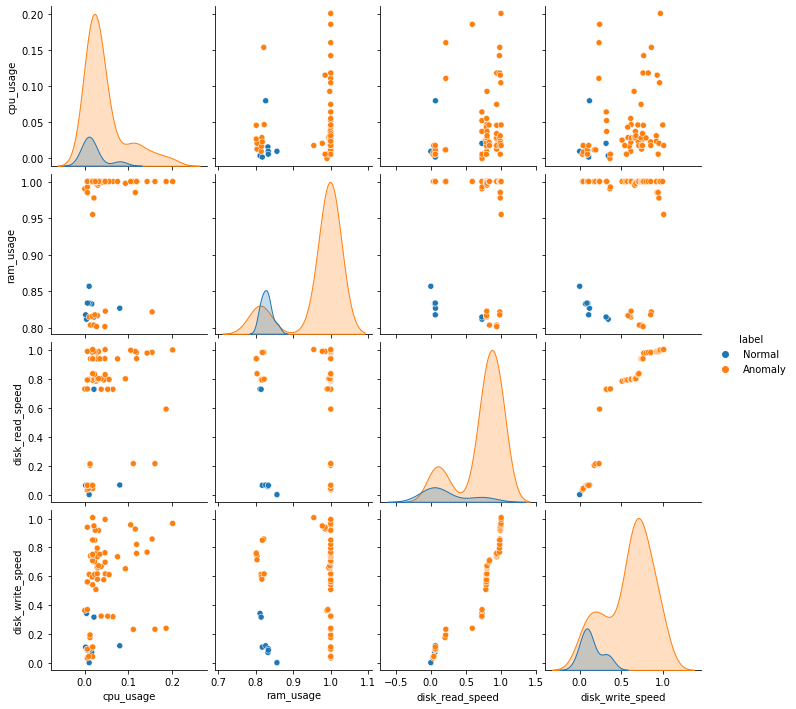

Confusion Matrix:
[[53  0]
 [10  8]]

---

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91        53
         1.0       1.00      0.44      0.62        18

    accuracy                           0.86        71
   macro avg       0.92      0.72      0.76        71
weighted avg       0.88      0.86      0.84        71



In [5]:
# Initialize the Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)

# Train the model on the non-anomalous training data
gmm.fit(X_train)

# Predict anomalies on the test data by calculating the log probability under the model
predictions = gmm.predict(X_test)

# Separate anomalies and normal data for visualization
anomalies = test_data[predictions == 0] # 0 for anomalies
normal = test_data[predictions == 1] # 1 for normal

# Combine normal and anomalies data with a label for easier plotting
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()

# Confusion Matrix
y_pred = np.where(predictions == 1, 1, 0)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\n---\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

c:\Users\asgar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\asgar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\asgar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\asgar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows wi

Best Parameters:
{'y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0]), 'n_components': 1, 'covariance_type': 'full', 'threshold': 0.5, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}

All Results:
    n_components covariance_type  threshold  accuracy  precision  recall  f1_score
0              1            full        0.5       1.0        1.0     1.0       1.0
1              1            full        1.0       1.0        1.0     1.0       1.0
2              1            full        1.5       1.0        1.0     1.0       1.0
3              1            full        2.0       1.0        1.0     1.0       1.0
4              1            full        2.5       1.0        1.0     1.0       1.0
..           ...             ...        ...       ...        ...     ...       ...
95 

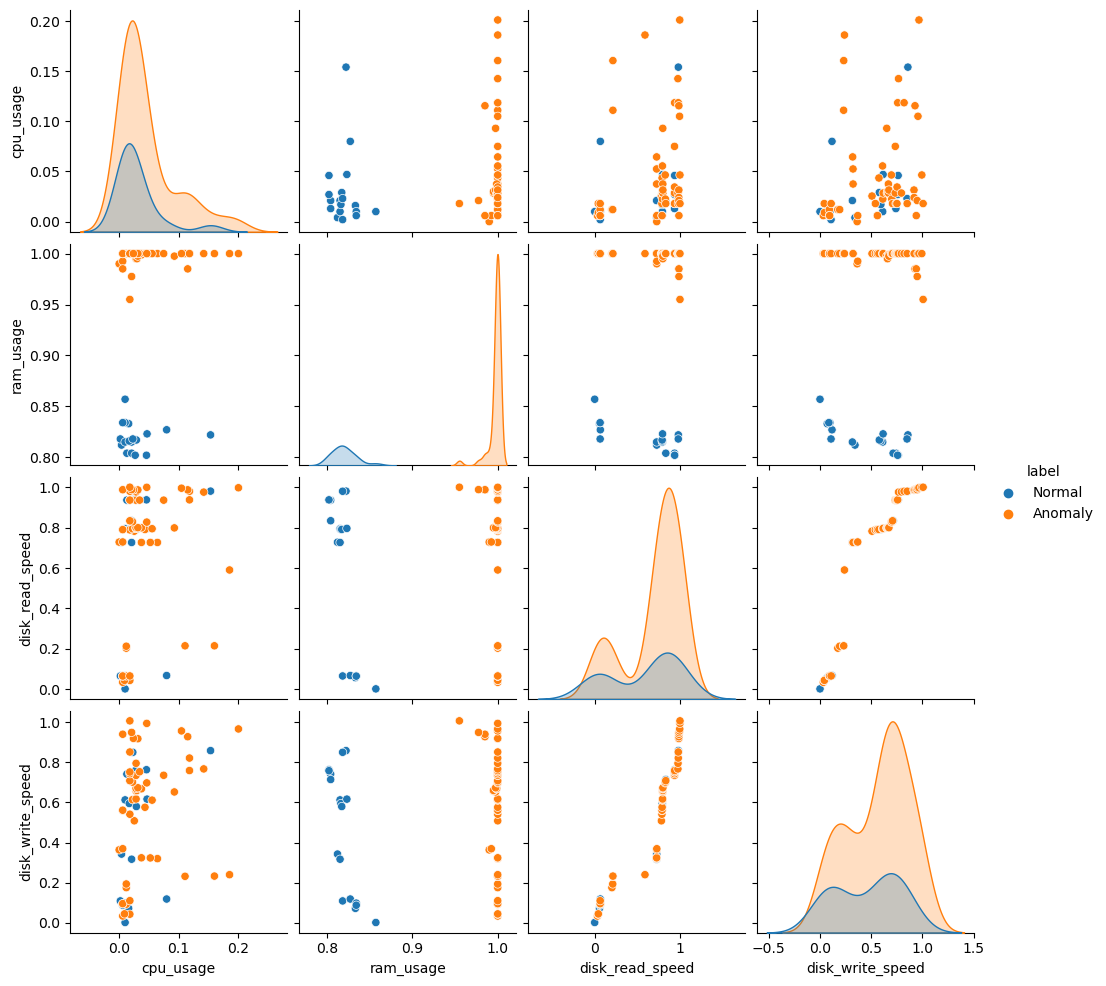

In [ ]:
from typing import List, Literal
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


# Define ranges for hyperparameters
n_components_list = [1, 2, 3, 4, 5]
covariance_types: List[Literal['full', 'tied', 'diag', 'spherical']] = ['full', 'tied', 'diag', 'spherical']
thresholds = [0.5, 1.0, 1.5, 2.0, 2.5]

# Initialize results list
results = []
best_f1 = 0

for n_components in n_components_list:
    for covariance_type in covariance_types:
        # Initialize the Gaussian Mixture Model (GMM) with current hyperparameters
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=42
        )
        
        # Train the model on the non-anomalous training data
        gmm.fit(X_train)
        
        # Calculate the log probability for test data under the model
        log_probs = gmm.score_samples(X_test)  # Get log-likelihoods for each sample
        
        # Loop through thresholds to classify anomalies
        for threshold in thresholds:
            # Calculate anomaly scores (negative log-likelihood)
            anomaly_scores = -log_probs
            predictions = np.where(anomaly_scores > threshold, 0, 1)  # 0 for anomalies, 1 for normal
            
            # Evaluate classification metrics
            accuracy = accuracy_score(y_true, predictions)
            precision = precision_score(y_true, predictions, zero_division=0)
            recall = recall_score(y_true, predictions, zero_division=0)
            f1 = f1_score(y_true, predictions, zero_division=0)

            results.append({
                'y_pred': predictions,
                'n_components': n_components,
                'covariance_type': covariance_type,
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })

            # Track best F1-score and corresponding parameters
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'y_pred': predictions,
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'threshold': threshold,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                }

# Print the best parameters
print("Best Parameters:")
print(best_params)

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nAll Results:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide enough display width
print(results_df.drop(['y_pred'], axis=1))

# Sort the DataFrame by 'f1_score' in descending order
results_df_sorted = results_df.sort_values(by='f1_score', ascending=False)

# Print top results
print("\nTop Results:")
print(results_df_sorted.drop(['y_pred'], axis=1).head(35))

# Confusion Matrix of the best model
conf_matrix = confusion_matrix(y_true, best_params['y_pred'])
print("\nConfusion Matrix of the best model:")
print(conf_matrix)

# Pairplot of the best model
anomalies = test_data[best_params['y_pred'] == 0] # 0 for anomalies
normal = test_data[best_params['y_pred'] == 1] # 1 for normal
sns.pairplot(
    data=pd.concat([normal.assign(label='Normal'), anomalies.assign(label='Anomaly')]),
    hue='label',
    vars=['cpu_usage', 'ram_usage', 'disk_read_speed', 'disk_write_speed'])
plt.show()